In [1]:
import mpramnist
from mpramnist.Sure.dataset import SureDataset

from mpramnist.models import HumanLegNet
from mpramnist.models import initialize_weights
from mpramnist.trainers import LitModel_Sure_Clas, LitModel_Sure_Reg

from mpramnist import transforms as t
from mpramnist import target_transforms as t_t

import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import pytorch_lightning as L

import torch.nn.functional as F

In [2]:
BATCH_SIZE = 1024
NUM_WORKERS = 103

In [3]:
from torch.nn.utils.rnn import pad_sequence

# preprocessing
train_transform = t.Compose([
    t.Seq2Tensor(),
    t.ReverseComplement(0.5),
])
test_transform = t.Compose([ # трансформы теста слегка другие
    t.Seq2Tensor(), 
])

def pad_collate(batch):
    (seq, targets) = zip(*batch)

    seq = pad_sequence(seq, batch_first=True, padding_value=0.25)

    return seq, torch.vstack(targets)

# Classification

In [4]:
GENOME_IDS = SureDataset.GENOME_IDS
CELL_TYPES = SureDataset.CELL_TYPES

In [5]:
task = "classification"

# load the data
train_dataset = SureDataset(task = task, genome_id = GENOME_IDS[0], 
                            split="train", transform=train_transform, root = "../data/")  # for needed folds
val_dataset = SureDataset(task = task, genome_id = GENOME_IDS[0], 
                          split="val", transform=test_transform, root = "../data/") # use "val" for default validation set
test_dataset = SureDataset(task = task, genome_id = GENOME_IDS[0], 
                           split="test", transform=test_transform, root = "../data/") # use "test" for default test set

In [6]:
N_CLASSES = train_dataset.num_outputs
in_channels = len(train_dataset[0][0][0])

In [7]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

val_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

In [8]:
model = HumanLegNet(in_ch=in_channels,
                     output_dim = N_CLASSES,
                     stem_ch=64,
                     stem_ks=11,
                     ef_ks=9,
                     ef_block_sizes=[80, 96, 112, 128],
                     pool_sizes=[2,2,2,2],
                     resize_factor=4)
model.apply(initialize_weights)

seq_model = LitModel_Sure_Clas(model = model,
                           loss = nn.CrossEntropyLoss(),
                           n_classes = N_CLASSES,
                           weight_decay = 1e-2, lr = 1e-2, print_each = 1)

In [9]:
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=1,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = False,
    num_sanity_val_steps=0
)

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



----------------------------------------------------------------------------------------------------
| K562: || Precision: 0.16931 | Recall: 0.20409 | Accuracy: 0.19960 | F1: 0.12066 | Val_AUCROC: 0.51249 | Val_AUPR: 0.20929 |
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
| HepG2: || Precision: 0.06981 | Recall: 0.19990 | Accuracy: 0.20260 | F1: 0.06787 | Val_AUCROC: 0.50949 | Val_AUPR: 0.20574 |
----------------------------------------------------------------------------------------------------



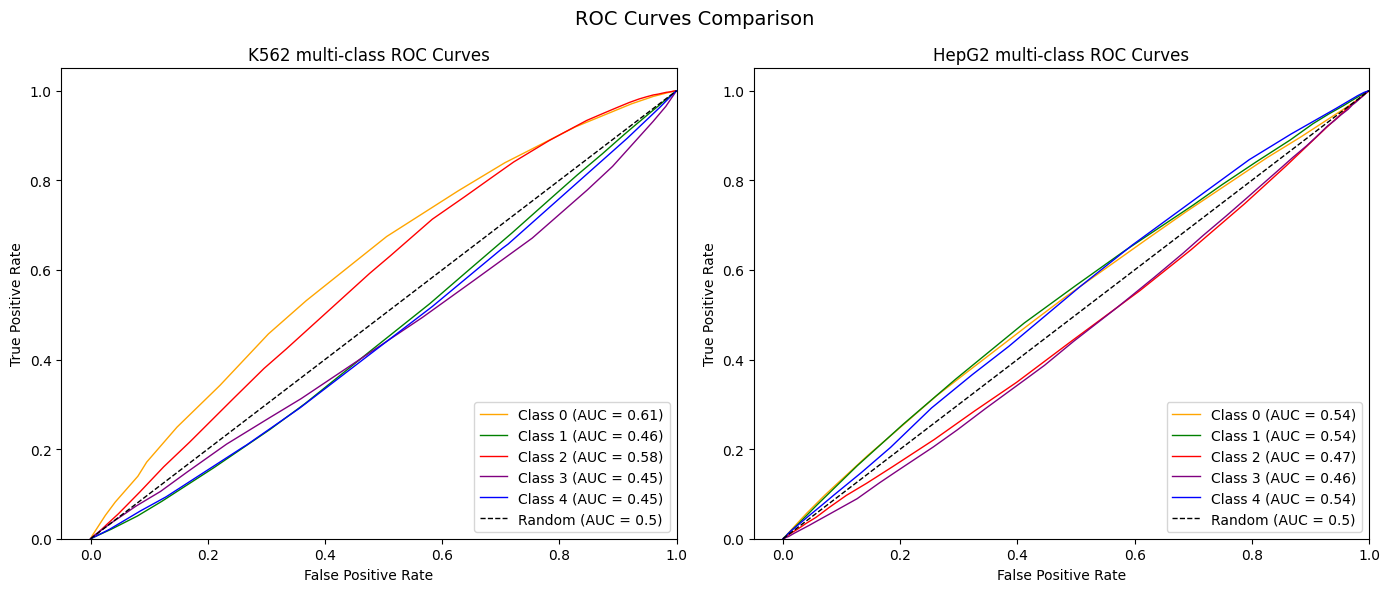

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss                 3.21875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 3.21875}]

In [10]:
# Train the model
'''
trainer.fit(seq_model,
            train_dataloaders = train_loader,
            val_dataloaders = val_loader)
            '''
trainer.test(seq_model, dataloaders = test_loader)

# Regression

In [4]:
task = "regression"

GENOME_IDS = SureDataset.GENOME_IDS
CELL_TYPES = SureDataset.CELL_TYPES

In [5]:
train_dataset = SureDataset(task = task, genome_id = GENOME_IDS[0],
                            split="train", transform=train_transform, root = "../data/")  # for needed folds

val_dataset = SureDataset(task = task, genome_id = GENOME_IDS[0],
                          split="val", transform=test_transform, root = "../data/") # use "val" for default validation set

test_dataset = SureDataset(task = task, genome_id = GENOME_IDS[0],
                           split="test", transform=test_transform, root = "../data/") # use "test" for default test set

In [6]:
num_outputs = train_dataset.num_outputs
in_channels = len(train_dataset[0][0][0])

In [7]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                               num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)

In [8]:
from torch_lr_finder import LRFinder
import matplotlib.pyplot as plt
model = HumanLegNet(in_ch = 4,
                         output_dim = 2,
                         stem_ch=64,
                         stem_ks=11,
                         ef_ks=9,
                         ef_block_sizes=[80, 96, 112, 128],
                         pool_sizes=[2,2,2,2],
                         resize_factor=4)
model.apply(initialize_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7, weight_decay = 0.01,)

criterion = nn.MSELoss() 

ModuleNotFoundError: No module named 'torch_lr_finder'

In [ ]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS, pin_memory=True, collate_fn=pad_collate)
lr_finder.range_test(train_loader, start_lr=1e-7, end_lr=10, num_iter=100)
lr_finder.plot()  
plt.show()

In [8]:
model = HumanLegNet(in_ch=in_channels,
                     output_dim = num_outputs,
                     stem_ch=64,
                     stem_ks=11,
                     ef_ks=9,
                     ef_block_sizes=[80, 96, 112, 128],
                     pool_sizes=[2,2,2,2],
                     resize_factor=4)
model.apply(initialize_weights)

seq_model = LitModel_Sure_Reg(model = model,
                           loss = nn.MSELoss(),
                           num_outputs = num_outputs,
                            lr = 2e-2, weight_decay = 5e-4, print_each = 1)

In [9]:
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=1,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    num_sanity_val_steps=0,
    enable_model_summary=False
)

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [10]:
# Train the model

trainer.fit(seq_model,
            train_dataloaders = train_loader,
            val_dataloaders = val_loader)
trainer.test(seq_model, dataloaders = test_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Training: |                                                                                       | 0/? [00:00…

/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=1` reached.



-------------------------------------------------------------------------------------------------------------------
| Epoch: 0 | Val Loss: 510.44733 | Val Pearson K562: 0.36261 | Val Pearson HepG2: 0.15997 | Train Pearson: 0.21216 
-------------------------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             530.1279296875
   test_pearson HepG2       0.1806412786245346
    test_pearson K562        0.369445264339447
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 530.1279296875,
  'test_pearson K562': 0.369445264339447,
  'test_pearson HepG2': 0.1806412786245346}]